## Описание проекта

Условная компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

## Цель
Построить модель для прогнозирования количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Столбец  **datetime** - дата  
столбец **num_orders** - количество заказов

# 1. Подготовка

In [315]:
import pandas  as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

Открываем данные

In [316]:
data_taxi = pd.read_csv('/datasets/taxi.csv')

In [317]:
data_taxi.info()
data_taxi.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Меняет формат даты

In [318]:
data_taxi['datetime'] = pd.to_datetime(data_taxi['datetime'], format='%Y.%m.%d %H:%M:%S')

Ставим дату индексом

In [319]:
data_taxi.set_index('datetime', inplace = True)

Ресемплируем по одному часу

In [320]:
data_taxi = data_taxi.resample('1H').sum()

Проверяем, находятся ли данные в хронологическом порядке

In [321]:
data_taxi.index.is_monotonic

True

#### Вывод  
Данные ресемплированы по одному часу и располагаются в хронологическом порядке

# 2. Анализ

Посмотрим как выглядит график количества заказов в час

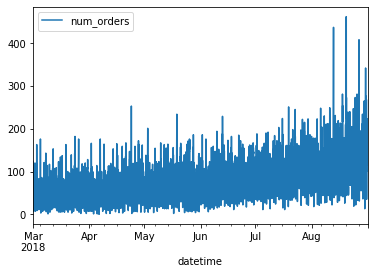

In [322]:
data_taxi.plot()

На графике наблдается некоторый тренд: посмотрим отдельно тренд и сезонность

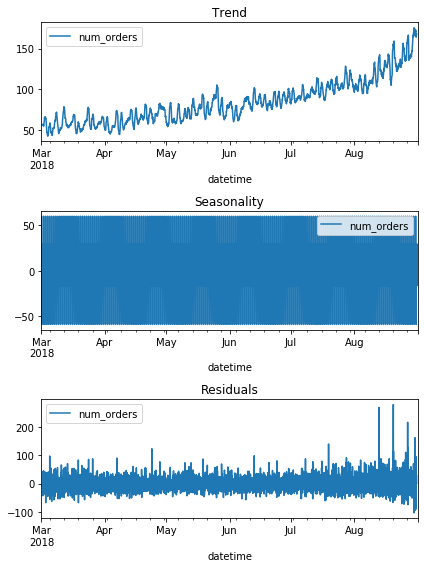

In [323]:
decomposed = seasonal_decompose(data_taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Рассмотрим сезонность поподробнее: возьмем первые десять дней марта, июня и августа

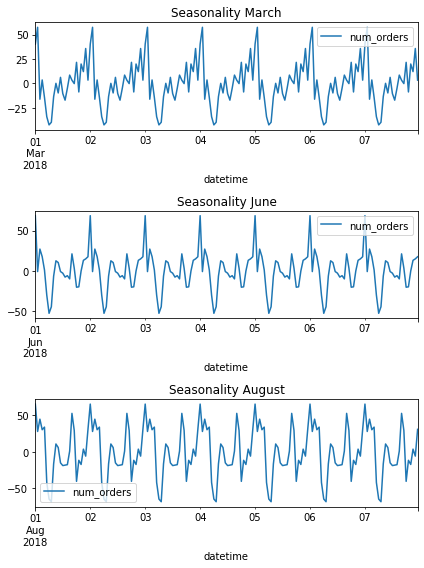

In [324]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed = seasonal_decompose(data_taxi['2018-03':'2018-03-7'])
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality March')
plt.subplot(312)
decomposed = seasonal_decompose(data_taxi['2018-06':'2018-06-7'])
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality June')
plt.subplot(313)
decomposed = seasonal_decompose(data_taxi['2018-08':'2018-08-7'])
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality August')
plt.tight_layout()

На графике сезонности наблюдается внутрисуточная сезонность, при этом в каждом месяце наблюдаются свои особенности. Также стоит отменить отсутствие внутринедельной сезонности, скорее всего это связано с тем, что ресемплирование проводилось по одному часу, поэтому попробуем ресемплировать по дню и посмотреть, появится или нет внутринедельная сезонность.

In [325]:
data_taxi_week = data_taxi.resample('1D').sum()

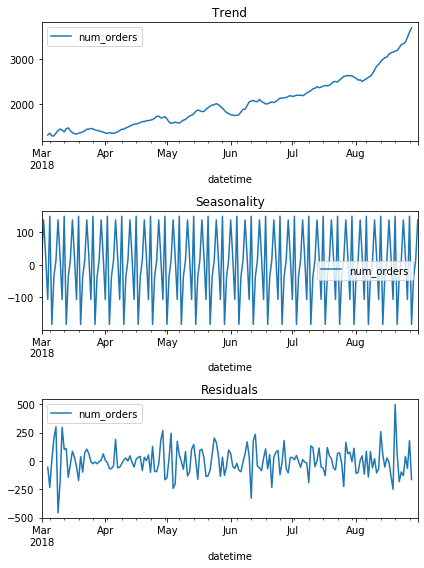

In [326]:
decomposed = seasonal_decompose(data_taxi_week)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Внутринедельная сезонность действительно появилась.

#### Вывод  
Наблюдается тренд к увеличению заказов, а также внутрисуточная сезонность, имеющая свои особенности в каждом месяце, и внутринедельная.

# 3. Обучение

Так как одного признака маловато для построения прогнозов, то необходимо добавить ещё признаков.  
Добавим признак **day_sum** - количество закаов за день, который получается с помощью ресемплирования данных по дню, получившиеся пропуски заполняем предыдущим значением.

In [327]:
data_taxi['day_sum'] = data_taxi.resample('1D').sum()
data_taxi.fillna(method='ffill', inplace = True)

Зададим функцию, которая будет добавлять следующие признаки:  
* месяц - хоть месяцы и представлены всего по одному разу, но такой признак неоходим из-за наличия возрастающего тренда 
* день недели - внутринедельная сезонность найдена, поэтому этот признак может пригодиться 
* отставание, скользящее среднее, скользящее среднее стандартное отклонение - нужно больше признаков, но пусть модель сама решит, сколько будет достаточно.  
Также функция будет разбивать данные на тренировочную, валидационную и тестовую выборки.

In [328]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    
    train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1, random_state=12345)
    train = train.dropna()
    
    train, valid = train_test_split(train, shuffle=False, test_size=0.1, random_state=12345)
    
    target_train, target_valid, target_test = train['num_orders'], valid['num_orders'], test['num_orders']
    feature_train, feature_valid, feature_test = train.drop('num_orders', axis = 1), valid.drop('num_orders', axis = 1),test.drop('num_orders', axis = 1)
    return target_train, target_valid, target_test, feature_train, feature_valid, feature_test

#### Линейная регрессия

Рассмотрим линейую регрессию. Будем подбирать отставание и ширину окна для скользящего среднего

In [329]:
%%time
rmse_0 = data_taxi['num_orders'].max()
max_lag = 0
rolling_mean_size = 0
for i in range (4, 30, 1):
    for j in range (4, 30, 1):
        target_train, target_valid, target_test, feature_train, feature_valid, feature_test = make_features(data_taxi, i, j)
        model = LinearRegression()
        model.fit(feature_train, target_train)
        pred = model.predict(feature_valid)
        pred_train = model.predict(feature_train)
        rmse = mean_squared_error(target_valid, pred)**0.5
        rmse_train = mean_squared_error(target_train, pred_train)**0.5
        if (rmse < rmse_0):
            rmse_0 = rmse
            max_lag = i
            rolling_mean_size = j
            rmse_train = mean_squared_error(target_train, pred_train)**0.5
print('rmse =', rmse_0)
print('rmse_train =', rmse_train)
print('max_lag =', max_lag)
print('rolling_mean_size =', rolling_mean_size)

rmse = 32.06784240339622
rmse_train = 23.418871962355837
max_lag = 24
rolling_mean_size = 5
CPU times: user 1min 17s, sys: 1min 24s, total: 2min 42s
Wall time: 2min 42s


Лучшее значение метрики RMSE = 32 получилось при следующих параметрах **max_lag** = 24 и **rolling_mean_size** = 5. При этом значение RMSE на тренировочной выборке составило 23.42, то есть наблюдается некоторое переобучение модели

#### Случайный лес

В модели случайного леса будем подбирать следующие параметы:  отставание, равное ширине окна для скользящего среднего, и максимальную губину деревьев.

In [330]:
rmse_0 = data_taxi['num_orders'].max()
counter = 0
counter_2 = 0
for i in range (4, 24, 1):
    for j in range (10, 31, 10):
        target_train_forest, target_valid_forest, target_test_forest, feature_train_forest, feature_valid_forest, feature_test_forest = make_features(data_taxi, i, i)
        model_forest = RandomForestRegressor(max_depth = j, random_state = 12345)
        model_forest.fit(feature_train_forest, target_train_forest)
        pred = model_forest.predict(feature_valid_forest)
        pred_train = model_forest.predict(feature_train_forest)
        rmse = mean_squared_error(target_valid_forest, pred)**0.5
        if (rmse < rmse_0):
            rmse_0 = rmse
            counter = i
            max_depth = j
            rmse_train = mean_squared_error(target_train_forest, pred_train)**0.5
print('rmse =', rmse_0)
print('rmse_train =', rmse_train)
print('counter =', counter)
print('max_depth =', max_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

rmse = 32.74923294794158
rmse_train = 13.979727676521474
counter = 16
max_depth = 10


Лучшее значение метрики RMSE = 32.75 получилось при следующих параметрах: max_lag = rolling_mean_size = 16, max_depth = 10. Стоит отметить, что значение RMSE получилось хуже, чем в модели линейной регрессии, кроме того, переобучилась модель значительно сильнее, так как значение RMSE на тестовой выборке составило 14.

#### LightGBM

Для модели LGBM также подбираем отставание и ширину окна скользящего среднего

In [331]:

rmse_0 = data_taxi['num_orders'].max()
counter = 0
for i in range (4, 24, 1):
    target_train_LGBM, target_valid_LGBM, target_test_LGBM, feature_train_LGBM, feature_valid_LGBM, feature_test_LGBM = make_features(data_taxi, i, i)
    model_LGBM = lgb.LGBMRegressor(num_threads = 2,  random_state = 12345)
    model_LGBM.fit(feature_train_LGBM, target_train_LGBM)
    pred = model_LGBM.predict(feature_valid_LGBM)
    pred_train = model_LGBM.predict(feature_train_LGBM)
    rmse = mean_squared_error(target_valid_LGBM, pred)**0.5
    if (rmse < rmse_0):
        rmse_0 = rmse
        counter = i
        rmse_train = mean_squared_error(target_train_LGBM, pred_train)**0.5
print("rmse =", rmse_0)
print('rmse_train =', rmse_train)
print('counter =', counter)

rmse = 31.251234994786657
rmse_train = 10.480689058483325
counter = 16


Значение RMSE = 31.25 оказалось лучше, чем у модели линейной регрессии, но переобучение модели оказалось значетельно сильнее, так как RMSE на тренировочной выборке составило 10.48.

#### Вывод  
Лучше всего себя показала модель LightGBM, значение RMSE у которой составило 31.25. У случайного леса RMSE = 32.75, а у линейной регрессии RMSE = 32. Однако и LightGBM, и случайный лес переобучились значительно сильнее линейной регрессии, поэтому для теста выбирается модель случайно регрессии.

# 4. Тестирование

In [356]:
target_train_f, target_valid_f, target_test_f, feature_train_f, feature_valid_f, feature_test_f = make_features(data_taxi, 24, 5)
model.fit(feature_train_f, target_train_f)
pred = model.predict(feature_test_f)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred)**0.5)

RMSE тестовой выборки:  42.44174619320297


Посмотрим на графике, как соотносятся предсказанные данные с реальными

In [366]:
x_1 = target_test['2018-08-27':'2018-08-31']
x_2 = pd.DataFrame(index = target_test.index, data = pred)
x_2 = x_2['2018-08-27':'2018-08-31']

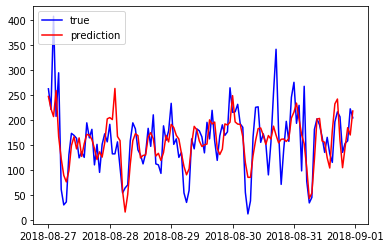

In [367]:
plt.plot(x_1.index, x_1, "-b", label="true")
plt.plot(x_2.index, x_2, '-r', label="prediction")
plt.legend(loc="upper left")
plt.show()

Из графика видно, что модель предсказывает хорошо небольшие колебания, а вот с резкими скачками вне внутрисуточной сезонности возникают проблемы.

#### Вывод  
Была выбрана модель линейной регрессии. Значение RMSE этой модели на тестовой выборке составило  42.44, что меньше заданного показателя, равного 48. Таким образом модель линейной регрессии можно применять для прогнозирования количества заказов такси на следующий час.